# Named Entity Recognition + Image Classification Pipeline on Animals-10 Dataset

**Dataset**

Dataset: https://www.kaggle.com/datasets/alessiocorrado99/animals10?select=translate.py\
That dataset contains about 28K medium quality animal images belonging to 10 categories: dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant.

**Main tasks:**
1. NLP (Named Entity Recognition - NER): Extract animal names from a given text.
2. Computer Vision (Image Classification): Identify which animal is in the given image.

So let's start

In [1]:
import json
import os
import random
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from wordcloud import WordCloud

# Prevents OpenMP (libiomp5md.dll) initialization error when using NumPy, TensorFlow, or PyTorch  
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" 

## Animal Text Dataset (NER - NLP)

The dataset was generated using a custom-designed prompt to ensure:

-  Balanced representation of 10 specific animal categories - each class appears approximately 1900 times
-  Varied sentence complexity - mix of simple and complex sentences
-  Correct IO annotations (`I-[CLASS]` for animal mentions, `O` for non-entity words).
-  Multiple words per class – each animal class includes synonyms and variations

In [9]:
# File paths
file_path = "../data/ner-dataset/animal_sentences.json"

# Load JSON files
with open(file_path, "r", encoding="utf-8") as f:
    dataset = json.load(f)


# Convert to a Pandas DataFrame for analysis
df = pd.DataFrame(dataset)

#### Animal Class Distribution

In [10]:
# Extract entity counts
entity_counts = Counter()
word_counts = Counter()
unique_words_by_class = {}

for entry in dataset:
    for token, tag in zip(entry["tokens"], entry["tags"]):
        if tag != "O":  # If it's an entity
            entity_counts[tag] += 1
            word_counts[token.lower()] += 1  # Normalize words to lowercase
            
            # Store unique words per class
            if tag not in unique_words_by_class:
                unique_words_by_class[tag] = Counter()
            unique_words_by_class[tag][token.lower()] += 1

# Convert entity counts to a DataFrame
entity_counts_df = pd.DataFrame(entity_counts.items(), columns=["Class", "Count"])
print(entity_counts_df)

         Class  Count
0        I-DOG   1853
1     I-SPIDER   1849
2    I-CHICKEN   1845
3      I-HORSE   1860
4  I-BUTTERFLY   1912
5        I-COW   1886
6   I-SQUIRREL   1854
7      I-SHEEP   1849
8        I-CAT   1840
9   I-ELEPHANT   1896


Generated dataset is balanced and each class appears approximately 1900 times.

#### Unique values per class

In [12]:
# Prepare unique words per class DataFrame
unique_words_data = []

for tag, words in unique_words_by_class.items():
    unique_words_data.append({"Class": tag, "Unique Words": list(words.keys()), "Total Unique": len(words)})

unique_words_df = pd.DataFrame(unique_words_data)
print(unique_words_df.to_string(index=False))

      Class                                      Unique Words  Total Unique
      I-DOG        [puppies, dogs, puppy, dog, canine, hound]             6
   I-SPIDER            [spider, spiders, tarantula, arachnid]             4
  I-CHICKEN [hens, hen, roosters, chickens, chicken, rooster]             6
    I-HORSE      [horses, foals, mare, stallion, horse, foal]             6
I-BUTTERFLY                    [butterflies, butterfly, moth]             3
      I-COW            [bull, cow, calf, bulls, cows, calves]             6
 I-SQUIRREL                   [squirrel, squirrels, chipmunk]             3
    I-SHEEP                         [lamb, sheep, lambs, ram]             4
      I-CAT              [kitten, cats, cat, kittens, feline]             5
 I-ELEPHANT            [elephants, elephant, pachyderm, calf]             4


Every class has at least 3 unique words

#### Sentence length statistics

In [15]:
# Compute sentence length statistics
sentence_lengths = [len(entry["tokens"]) for entry in dataset]

# Compute basic statistics
sentence_length_stats = {
    "Min Length": min(sentence_lengths),
    "Max Length": max(sentence_lengths),
    "Mean Length": sum(sentence_lengths) / len(sentence_lengths),
    "Median Length": sorted(sentence_lengths)[len(sentence_lengths) // 2],
    "Standard Deviation": pd.Series(sentence_lengths).std()
}

# Convert to DataFrame for better visualization
sentence_length_df = pd.DataFrame([sentence_length_stats])
print(sentence_length_df.to_string(index=False))

 Min Length  Max Length  Mean Length  Median Length  Standard Deviation
          5          13       8.3514              8              1.8579


The sentence length statistics confirm that the dataset has varied sentence complexity. Mean Length and Median show that most sentences are mid-length, ensuring good variation without extreme shortness or verbosity.

#### Word cloud visualization

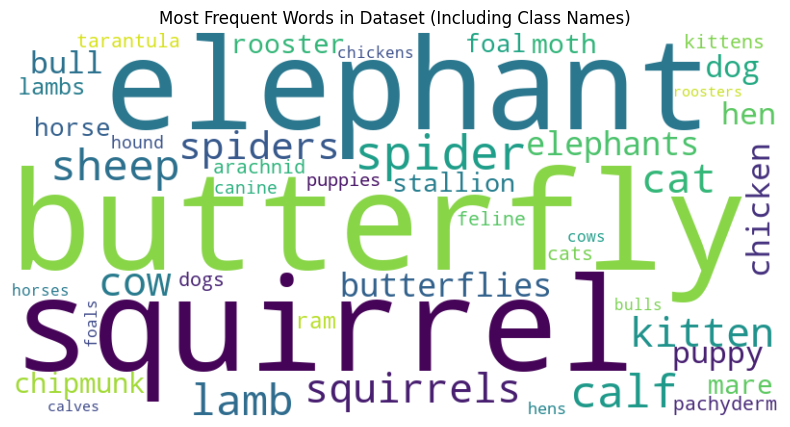

In [ ]:
# Generate a word cloud of frequent words
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts)

# Plot the word cloud 😶‍🌫️
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Dataset (Including Class Names)")
plt.show()

The word cloud above visualizes the most frequent animal-related words in the dataset, including:
-  Animal class names
-  Synonyms & variations 
-  Plural & singular forms

The larger words represent more frequent mentions, confirming that all 10 animal classes are well-represented in the dataset. 

## Animal Image Dataset

In [ ]:
# Define dataset path
dataset_path = "../data/raw-img"

# Load class names translation
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "scoiattolo": "squirrel", "ragno": "spider"
}

# Collect class distribution information
class_counts = {}
image_samples = {}

for folder in os.listdir(dataset_path):
    class_name = translate.get(folder, folder)  # Convert to English names
    class_folder = os.path.join(dataset_path, folder)
    
    if os.path.isdir(class_folder):
        images = os.listdir(class_folder)
        class_counts[class_name] = len(images)

        if images:
            image_samples[class_name] = os.path.join(class_folder, images[0])

class_distribution_df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])

In [ ]:
total_images = sum(class_counts.values())
print(f"Total number of images: {total_images}")

Total number of images: 26179


### Images Visualization

Let's build a function which will display 9 random images of different classes to understand how images look like.

In [ ]:
def show_random_images(dataset_path, translate, num_images=9):
    """
    Displays a 3x3 grid of random images from different classes.
    """
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    all_classes = list(translate.keys())

    # Randomly select classes
    selected_classes = random.sample(all_classes, min(num_images, len(all_classes)))

    for ax, class_name in zip(axes.flatten(), selected_classes):
        # Get class folder and images
        class_folder = os.path.join(dataset_path, class_name)
        images = os.listdir(class_folder)
        
        if images:
            # Pick a random image
            img_path = os.path.join(class_folder, random.choice(images))
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            ax.imshow(img)
            ax.set_title(translate[class_name])  # Use English class name
            ax.axis("off")

    plt.suptitle("Random 3x3 Image Samples", fontsize=16)
    plt.show()

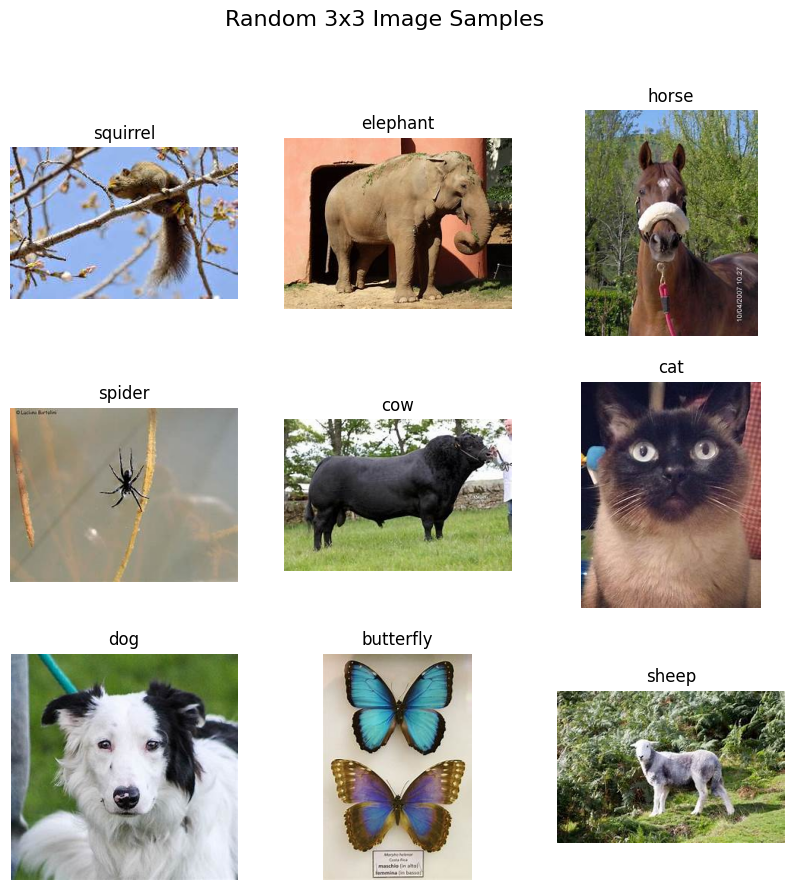

In [ ]:
show_random_images("../data/raw-img", translate)

#### Class Distribution Plot

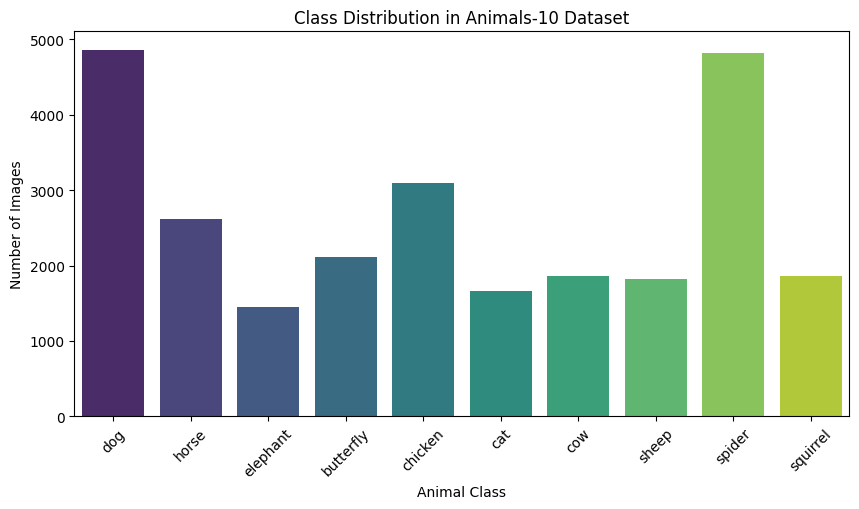

In [ ]:
# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_distribution_df["Class"], y=class_distribution_df["Image Count"], palette="viridis", hue = class_distribution_df["Class"])
plt.xticks(rotation=45)
plt.xlabel("Animal Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Animals-10 Dataset")
plt.show()

The dataset is not balanced; some classes (like "dog" and "spider") have significantly more images than others. This could lead to biased training, where the model may perform better on overrepresented classes. We might augment the images of underrepresented classes and decrease the number of images in overrepresented classes, this approach helps us to balance the dataset.

Since we have only 26 thousand images, we can apply image augmentation for underrepresented classes(increase each class to 3000) and perform mild undersampling for overrepresented classes (decrease each class to 3000).

The process of image augmentation and preprocessing is making in the `train_image.py` script, so let's import all necessary functions and check how looks like the image augmentation process.

In [41]:
import sys
sys.path.append("..")
from src.img_classification.train_image import AnimalDataset, preprocessing_transforms, augmentation_transforms
sys.path.append("notebooks")

In [42]:
# Create dataset with preprocessing & augmentation
animal_dataset = AnimalDataset(dataset_path, translate, augment=True)

In [43]:
# Function to Show Augmented vs. Original Image
def show_augmentation_effect(dataset, num_samples=6):
    """ Displays original & augmented images side by side """
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 3))

    for i in range(num_samples):
        img_path, label, _ = dataset.image_paths[i]
        image = Image.open(img_path).convert("RGB")

        # Apply standard preprocessing (Original Image)
        orig_img = preprocessing_transforms(image)
        orig_img = orig_img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        orig_img = (orig_img * 0.5) + 0.5  # 🔹 Denormalize to [0,1] range

        # Apply Augmentation (Transformed Image)
        aug_img = augmentation_transforms(image)
        aug_img = aug_img.permute(1, 2, 0).numpy()
        aug_img = (aug_img * 0.5) + 0.5  # 🔹 Denormalize to [0,1] range

        # Show images
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(aug_img)
        axes[i, 1].set_title("Augmented Image")
        axes[i, 1].axis("off")

    plt.suptitle("Original vs Augmented Images", fontsize=16)
    plt.show()

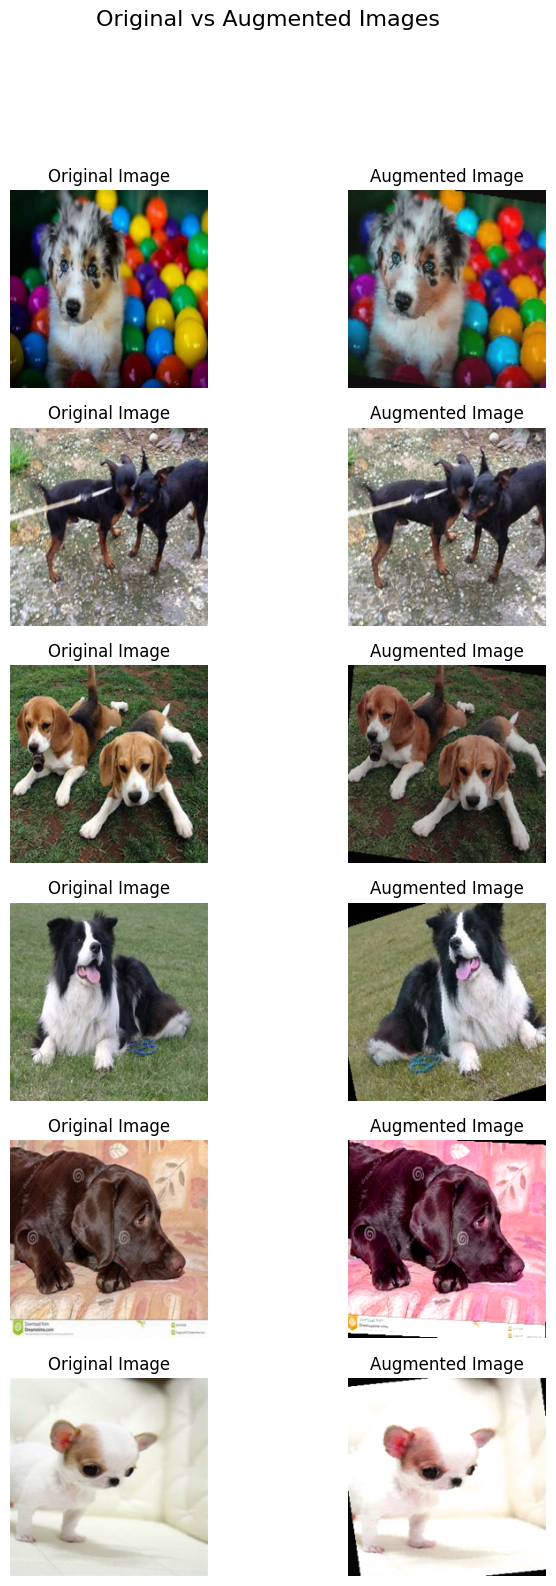

In [44]:
show_augmentation_effect(animal_dataset)

Good!